In [27]:
%load_ext autoreload
%autoreload 2
import logging

logging.getLogger('mat73').setLevel(logging.CRITICAL)
import os
import glob
import re
from scipy.io import loadmat
import mat73
logging.getLogger('mat73').setLevel(logging.CRITICAL)

import warnings

from collections import Counter
import pandas as pd
import numpy as np
import mne

import seaborn as sns
import matplotlib.pyplot as plt
# import holoviews as hv
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

from utils import *
from connectivity_dynamics import *

INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [28]:
## Plotting settings
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['axes.labelweight']
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams.update({'axes.titlesize': 'large'})
plt.rcParams['ytick.left'] = True
rc = {'figure.figsize':(5,5), 'ytick.left':True,'xtick.bottom':True ,
'xtick.major.size':20,
'xtick.major.width':40,
'xtick.minor.size':10,
'xtick.minor.width':2,
'xtick.labelsize':14,
'font.sans-serif': "Arial",
"font.family":"sans-serif",
"axes.linewidth":10,
'font.weight': 'bold',
'figure.figsize':(4,8)
}

In [3]:
from pandarallel import pandarallel

# Calculating Connectivity Between Channels

It seems my task is much easier than I previously thought. There are designated recordings for my 4 periods of interested already cleaned and labelled by Derek and Graham. Bless.

Goal for this section's exploration: calculate ISH across 4 periods for 1 patient.
1. Find 4 recordings for patient
1. Calc Connectivity (PDC) for each recording
1. Im show some of those recordings
1. calculate inward-outward strengh for 4 periods - ISH
1. BONUS: Redo 1-4 with cross spectral coherence connectivity from the French

## Setup Flow Between States

In [6]:
DATA_DIR = '/mnt/ernie_main/Ghassan/ephys/data/z_flow'
flow_files = glob.glob(os.path.join(DATA_DIR, "peri_ictal_flow_verbose_*pat*_centered.csv"))
power_bals = glob.glob('/mnt/ernie_main/Ghassan/ephys/data/ei_bal/*scored_power_bal_*_centered.csv')
robust_regions = set(['tx-lh-parsorbitalis', 'ctx-lh-cuneus', 'ctx-lh-lingual','ctx-rh-medialorbitofrontal','ctx-rh-temporalpole'])
susceptible_regions = set(['Left-Putamen', 'ctx-lh-tansversetemporal','ctx-rh-inferiorparietal','ctx-lh-bankssts','ctx-rh-superiorparietal','ctx-rh-bankssts', 'ctx-rh-lateraloccipital','ctx-rh-lingual','ctx-rh-inferiortemporal'])

# Robust Region Flow Analysis 

In [ ]:

robust_flow_dfs = []
susceptible_flow_dfs = []
grp_flow_dfs = []
check_list = []
robustcount = 0
sus_count = 0
for f in power_bals:
    if "Spat18" in f or "Spat17" in f or "Epat20" in f:
        continue
    pow_df = pd.read_csv(f).rename(columns={'window_designationas':'window_designations'})
    if len(robust_regions.intersection(pow_df.anat_region)) > 0:
        subj = pow_df.patID.values[0]
        try:
            ind = np.where([subj in f for f in flow_files])[0][0]
        except IndexError:
            logger.warning(f"Robust anatomy found in {subj} but BUT NO FLOW found!")
            continue
        flow_f = flow_files[ind]
        logger.info(f"Robust anatomy found in {subj} loading {flow_f}")
        peri_df = pd.read_csv(flow_f)
        robust_df= pow_df[pow_df.anat_region.isin(robust_regions)]
        robust_dict = dict(zip(robust_df.bip, robust_df.anat_region))
        robust_bips = set(robust_df.bip)
        peri_df = peri_df[peri_df.src_bip.isin(robust_bips)]

        peri_df['anat_region'] = [robust_dict[bip] for bip in peri_df.src_bip]
        robust_flow_dfs.append(peri_df)
        robustcount += 1
    if len(susceptible_regions.intersection(pow_df.anat_region)) >0:
        subj = pow_df.patID.values[0]
        try:
            ind = np.where([subj in f for f in flow_files])[0][0]
        except IndexError:
            logger.warning(f"Susceptible anatomy found in {subj} but BUT NO FLOW found!")
            continue
        flow_f = flow_files[ind]
        logger.info(f"Susceptible anatomy found in {subj} loading {flow_f}")
        peri_df = pd.read_csv(flow_f)
        susceptible_df= pow_df[pow_df.anat_region.isin(susceptible_regions)]
        susceptible_dict = dict(zip(susceptible_df.bip, susceptible_df.anat_region))
        susceptible_bips = set(susceptible_df.bip)
        peri_df = peri_df[peri_df.src_bip.isin(susceptible_bips)]

        peri_df['anat_region'] = [susceptible_dict[bip] for bip in peri_df.src_bip]
        susceptible_flow_dfs.append(peri_df)
        sus_count += 1
    # try:
    # peri_event_df = center_onset(peri_df)

    #grp_flow_dfs.append(peri_df)
    # except IndexError as e:
    #     print(f) 
    #     check_list.append(f)
logger.info(f"Robust anatomy found in {robustcount} patients\nSusepctiable found in {sus_count}")
robust_flow_dfs = pd.concat(robust_flow_dfs)
susceptible_flow_dfs = pd.concat(susceptible_flow_dfs)
# flow_df = pd.read_csv(os.path.join(DATA_DIR,f))
# flow_df.columns = ['source', 'target', 'value', 'period', 'window_designations', 'eventID',
#        'patID', 'sz_type']
# flow_df = center_onset(flow_df)

2024-10-25 17:53:18.263 | INFO     | __main__:<module>:19 - Robust anatomy found in Epat08 loading /mnt/ernie_main/Ghassan/ephys/data/z_flow/peri_ictal_flow_verbose_Epat08_centered.csv


In [72]:
grp_flow_dfs = grp_flow_dfs.dropna()

In [14]:
pandarallel.initialize()


INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [15]:
robust_flow_dfs['src_trgt'] = robust_flow_dfs.parallel_apply(lambda x : x['anat_region']+ "_"+x['target'], axis=1)
sus_flow_dfs = susceptible_flow_dfs

sus_flow_dfs['src_trgt'] = sus_flow_dfs.parallel_apply(lambda x : x['anat_region']+ "_"+x['target'], axis=1)
#nz_df = flow_df[flow_df.src_trgt.isin(['nz_soz','nz_pz'])]
#nz_df

In [7]:
# grp_flow_dfs['src_trgt'] = grp_flow_dfs.apply(lambda x : x['source']+ "_"+x['target'], axis=1)

In [16]:
tmp_df = sus_flow_dfs[sus_flow_dfs.freq_band=='alpha']
peri_stats_df = tmp_df[['src_trgt','value','patID','win_sz_st_end']].groupby(['patID','src_trgt', 'win_sz_st_end',]).mean().reset_index()
peri_stats_df.shape[0]

117024

In [56]:

COLOR_MAP['niz_soz'] = COLOR_MAP['soz']
COLOR_MAP['nz_soz'] = COLOR_MAP['soz']
COLOR_MAP['niz_pz'] = COLOR_MAP['pz']
COLOR_MAP['nz_pz'] = COLOR_MAP['pz']
COLOR_MAP['niz_niz'] = COLOR_MAP['nz']
COLOR_MAP['nz_nz'] = COLOR_MAP['nz']

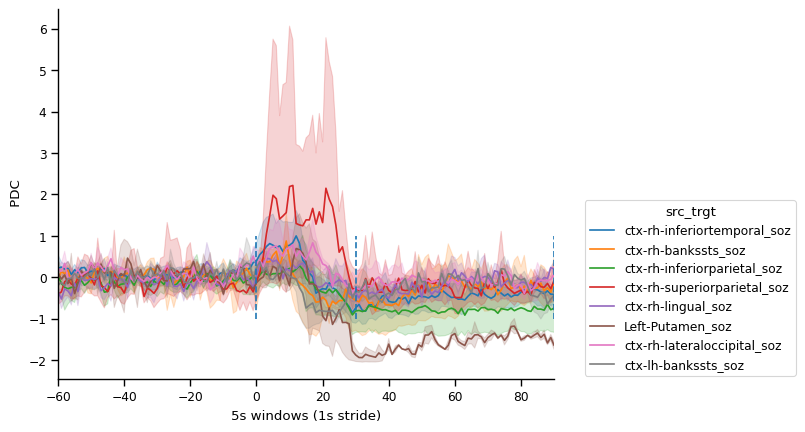

In [17]:
# plot_df = peri_stats_df[['src_trgt', 'win_sz_st_end','value']]
# plot_df = plot_df[plot_df.src_trgt.isin(['nz_nz', 'nz_pz', 'nz_soz'])]
plot_df = peri_stats_df[[ src_trgt.split("_")[-1] == 'soz' for src_trgt in peri_stats_df.src_trgt.values]]
# plot_df = plot_df[~plot_df.src_trgt.isin(['ctx-lh-cuneus_soz', 'tx-lh-parsorbitalis_soz'])]
with sns.plotting_context("paper"):
    ax = sns.lineplot(plot_df, x='win_sz_st_end', y='value',hue='src_trgt')
    ax.vlines(x = [-60,0, 30, 90], ymin = -1, ymax = 1,linestyles ='dashed')
    plt.xlim(-60,90)
    plt.xlabel("5s windows (1s stride)")
    plt.ylabel(" PDC")
    sns.despine()
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1.05, 0.5))
    plt.savefig("../viz/nz_ROBUST_flow_z.pdf",transparent=True)
# There are a lot of regions labelled NIZ that end up "seized" during the ic

# Summary Region Flow analysis 

In [9]:
grp_flow_dfs = []

grp_cols = ['patID', 'eventID','sz_type','freq_band','win_sz_st_end', 'source','target' ,'value']
for f in flow_files:
    df = pd.read_csv(f)
    #df = df[grp_cols].groupby(by=grp_cols[0:-1]).mean().reset_index()
    grp_flow_dfs.append(df)
    break
grp_flow_dfs = pd.concat(grp_flow_dfs)

In [10]:
df

,Unnamed: 0,win_label,win_sz_st_end,sz_end,win_sz_centered,source,target,src_bip,value,period,window_designations,freq_band,eventID,patID,sz_type
0,1974024,interictal,-595,289,-595,soz,soz,AH1AH2,-0.085348,0,0.0_0.0_0.0,delta,5,Epat06,FIAS
1,1974025,interictal,-595,289,-595,soz,soz,AH2AH3,0.865508,0,0.0_0.0_0.0,delta,5,Epat06,FIAS
2,1974026,interictal,-595,289,-595,soz,soz,AH3AH4,0.542405,0,0.0_0.0_0.0,delta,5,Epat06,FIAS
3,1974027,interictal,-595,289,-595,soz,soz,AH4AH5,0.150450,0,0.0_0.0_0.0,delta,5,Epat06,FIAS
4,1974028,interictal,-595,289,-595,soz,pz,AH1AH2,-0.284897,0,0.0_0.0_0.0,delta,5,Epat06,FIAS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010271,998635,post_ictal,623,270,864,nz,nz,I6I7,0.470399,1459,2.0_2.0_2.0,gamma_H,2,Epat06,FBTC
2010272,998636,post_ictal,623,270,864,nz,nz,I7I8,-0.016018,1459,2.0_2.0_2.0,gamma_H,2,Epat06,FBTC
2010273,998637,post_ictal,623,270,864,nz,nz,I9I10,0.091697,1459,2.0_2.0_2.0,gamma_H,2,Epat06,FBTC
2010274,998638,post_ictal,623,270,864,nz,nz,PC1PC2,-0.481932,1459,2.0_2.0_2.0,gamma_H,2,Epat06,FBTC


In [12]:
grp_flow_dfs['src_trgt'] = grp_flow_dfs.parallel_apply(lambda x : x['source']+ "_"+x['target'], axis=1)

peri_stats_df = grp_flow_dfs[['src_trgt','value','patID','win_sz_st_end']].groupby(['patID','src_trgt', 'win_sz_st_end',]).mean().reset_index()
peri_stats_df.shape[0]

642413

/tmp/ipykernel_114579/975234131.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


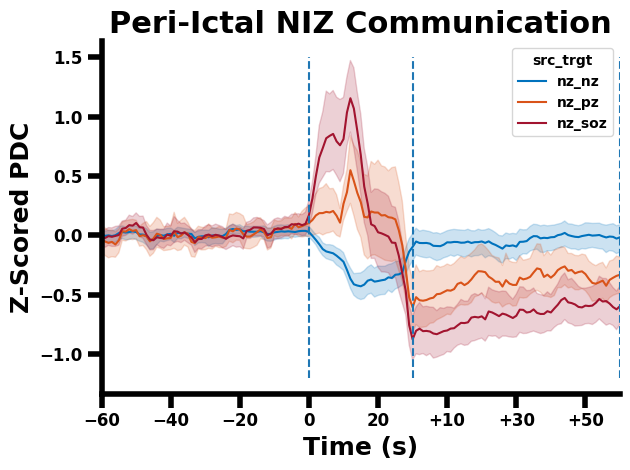

In [18]:

sns.set_style( rc=rc)
plot_df = peri_stats_df[['src_trgt', 'win_sz_st_end','value']]
plot_df = plot_df[plot_df.src_trgt.isin(['nz_nz', 'nz_pz', 'nz_soz'])]
ax = sns.lineplot(plot_df, x='win_sz_st_end', y='value',hue='src_trgt',palette=COLOR_MAP)

plt.title("Peri-Ictal NIZ Communication", weight='bold', fontsize=22)
plt.ylabel("Z-Scored PDC", weight='bold', fontsize= 18)
plt.xlabel("Time (s)", weight='bold', fontsize=18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


ax.vlines(x = [-60,0, 30, 90], ymin=-1.2, ymax=1.5 ,linestyles ='dashed')

# thicken axes lines
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(4)
#Edit tick size, thickness, and labels
ax.tick_params(axis='both', which='major', labelsize=12, width=4, length=10)

plt.xlim(-60, 90)
# reset count to seizure end
labels = [item.get_text() for item in ax.get_xticklabels()]
labels = [f'+{str(int(l.replace("−","-")) -30)}' if int(l.replace("−", "-"))> 30 else l for l in labels]
ax.set_xticklabels(labels)
#last check to get everything bold
plt.rc("font", weight='bold')
plt.tight_layout()
plt.xlim(-60,90)
plt.savefig("../viz/nz_flow_z_scored.pdf",transparent=True)
# There are a lot of regions labelled NIZ that end up "seized" during the ictal 


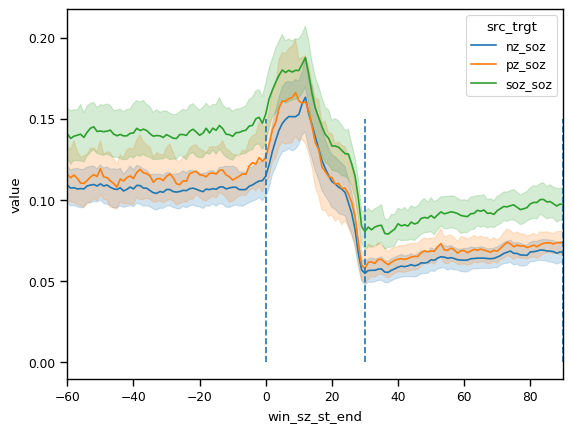

In [9]:
plot_df = peri_stats_df[['src_trgt', 'win_sz_st_end','value']]
plot_df = plot_df[plot_df.src_trgt.isin(['soz_soz', 'pz_soz', 'nz_soz'])]
with sns.plotting_context("paper"):
    ax = sns.lineplot(plot_df, x='win_sz_st_end', y='value',hue='src_trgt')
    ax.vlines(x = [-60,0, 30, 90], ymin = 0, ymax = .15,linestyles ='dashed')
    plt.xlim(-60,90)

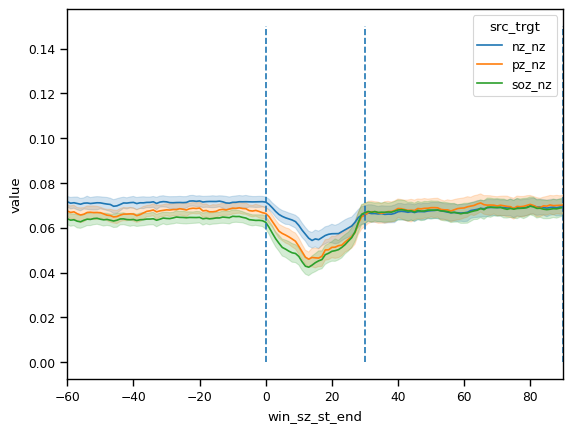

In [11]:
plot_df = peri_stats_df[['src_trgt', 'win_sz_st_end','value']]
plot_df = plot_df[plot_df.src_trgt.isin(['pz_nz', 'soz_nz', 'nz_nz'])]
with sns.plotting_context("paper"):
    ax = sns.lineplot(plot_df, x='win_sz_st_end', y='value',hue='src_trgt')
    ax.vlines(x = [-60,0, 30, 90], ymin = 0, ymax = .15,linestyles ='dashed')
    plt.xlim(-60,90)

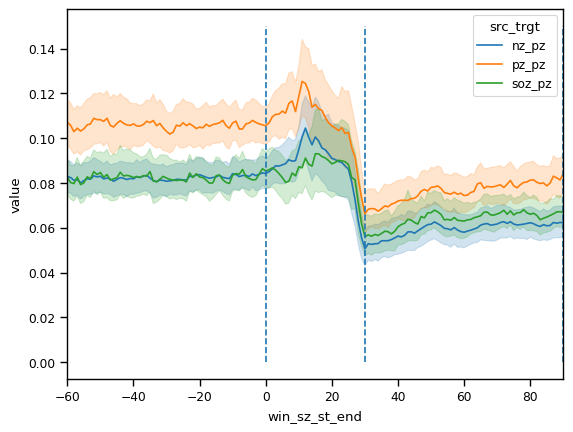

In [12]:
plot_df = peri_stats_df[['src_trgt', 'win_sz_st_end','value']]
plot_df = plot_df[plot_df.src_trgt.isin(['pz_pz', 'soz_pz', 'nz_pz'])]
with sns.plotting_context("paper"):
    ax = sns.lineplot(plot_df, x='win_sz_st_end', y='value',hue='src_trgt')
    ax.vlines(x = [-60,0, 30, 90], ymin = 0, ymax = .15,linestyles ='dashed')
    plt.xlim(-60,90)

In [7]:
band_df = flow_df[flow_df.band == 'gamma_H']
prev_period = ""
flow_stats_df = []
group_level_df =[]
for period in PERIOD:
    #group periods and fix source target labelling
    period_df = band_df[band_df.period == period]
    if prev_period !='':
        period_df['source'] = period_df.apply(lambda x: x['source'] +'_'+prev_period, axis=1)
    period_df['target'] = period_df.apply(lambda x: x['target'] +'_'+period, axis=1)
    prev_period = period

    #get per period statistics
    #first group within subjects
    group_stats_flow_df = period_df[['source','target','subj','value']].groupby(['source','target','subj']).mean()
    group_stats_flow_df = group_stats_flow_df.reset_index()
    group_level_df.append(group_stats_flow_df)
    # stats across groups now
    summary_df = group_stats_flow_df[['source','target','value']].groupby(['source','target']).mean().reset_index()


    flow_stats_df.append(summary_df)

flow_stats_df = pd.concat(flow_stats_df)
group_level_df = pd.concat(group_level_df)


/tmp/ipykernel_24915/3806023537.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  period_df['target'] = period_df.apply(lambda x: x['target'] +'_'+period, axis=1)
/tmp/ipykernel_24915/3806023537.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  period_df['source'] = period_df.apply(lambda x: x['source'] +'_'+prev_period, axis=1)
/tmp/ipykernel_24915/3806023537.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

In [8]:
group_level_df

,source,target,subj,value
0,nz,nz_inter,Epat02,61.643549
1,nz,nz_inter,Epat03,58.767143
2,nz,nz_inter,Epat04,69.977421
3,nz,nz_inter,Epat06,59.521534
4,nz,nz_inter,Epat08,23.667507
...,...,...,...,...
535,soz_ictal,soz_post,Spat50,0.411503
536,soz_ictal,soz_post,Spat51,13.157351
537,soz_ictal,soz_post,Spat52,0.708524
538,soz_ictal,soz_post,pat11,0.000000


In [9]:
from scipy.stats import f_oneway
nz_groups = group_level_df[group_level_df.target.isin(['nz_inter','nz_pre','nz_ictal','nz_post'])]
nzinter = nz_groups[nz_groups.target =='nz_inter'].value
nzpre = nz_groups[nz_groups.target =='nz_pre'].value
nzictal = nz_groups[nz_groups.target =='nz_ictal'].value
nzpost = nz_groups[nz_groups.target =='nz_post'].value
F, p = f_oneway(nzinter, nzpre, nzictal, nzpost)
print(f"F values: {F}")
print(f"p values: {p}")

F values: 0.634051377950704
p values: 0.593215585556679


In [10]:

pz_groups = group_level_df[group_level_df.target.isin(['pz_inter','pz_pre','pz_ictal','pz_post'])]
pzinter = pz_groups[pz_groups.target =='pz_inter'].value
pzpre = pz_groups[pz_groups.target =='pz_pre'].value
pzictal = pz_groups[pz_groups.target =='pz_ictal'].value
pzpost = pz_groups[pz_groups.target =='pz_post'].value
F, p = f_oneway(pzinter, pzpre, pzictal, pzpost)
print(f"F values: {F}")
print(f"p values: {p}")

F values: 0.26054736574445403
p values: 0.8538244183720844


In [11]:

soz_groups = group_level_df[group_level_df.target.isin(['soz_inter','soz_pre','soz_ictal','soz_post'])]
sozinter = soz_groups[soz_groups.target =='soz_inter'].value
sozpre = soz_groups[soz_groups.target =='soz_pre'].value
sozictal = soz_groups[soz_groups.target =='soz_ictal'].value
sozpost = soz_groups[soz_groups.target =='soz_post'].value
F, p = f_oneway(sozinter, sozpre, sozictal, sozpost)
print(f"F values: {F}")
print(f"p values: {p}")

F values: 6.009158792005015
p values: 0.00047985032325588244


# SVM for Verbose Bipole SOZ classification

In [64]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay

In [65]:
df = pd.read_csv("/mnt/ernie_main/Ghassan/ephys/data/z_flow/peri_ictal_flow_verbose_Epat13.csv")


NameError: name 'pd' is not defined

In [66]:
df = center_onset(df)
## Step 1 Center seizure onset and get right win_label

NameError: name 'center_onset' is not defined

In [13]:
df.win_label = df.win_sz_st_end.apply(label_timestamp)

In [20]:
# step 2 build X (data matrix) for each subject
# y will be the source label
# Step2.1 group by proper windows
grp_cols = ['patID','eventID','sz_type','source','src_bip','win_label','freq_band']
quant_cols = ['value', 'in_conn', 'out_conn', 'net_conn']
win_df = df[grp_cols + quant_cols].groupby(grp_cols).mean().reset_index()
win_df

,patID,eventID,sz_type,source,src_bip,win_label,freq_band,value,in_conn,out_conn,net_conn
0,Epat13,1,FIAS,nz,LA10LA11,early-ictal,alpha,0.180153,-0.242531,0.178511,-0.421043
1,Epat13,1,FIAS,nz,LA10LA11,early-ictal,beta,0.176003,-0.210883,0.197564,-0.408447
2,Epat13,1,FIAS,nz,LA10LA11,early-ictal,delta,0.238705,-0.181090,0.246958,-0.428048
3,Epat13,1,FIAS,nz,LA10LA11,early-ictal,gamma_H,0.545081,-0.201088,0.571860,-0.772948
4,Epat13,1,FIAS,nz,LA10LA11,early-ictal,gamma_l,0.249942,-0.163338,0.379062,-0.542400
...,...,...,...,...,...,...,...,...,...,...,...
26995,Epat13,8,"Focal, unknown awareness",soz,RPH4RPH5,pre-ictal,beta,1.339546,0.017909,-0.562400,0.580309
26996,Epat13,8,"Focal, unknown awareness",soz,RPH4RPH5,pre-ictal,delta,0.835276,0.037585,-0.171627,0.209212
26997,Epat13,8,"Focal, unknown awareness",soz,RPH4RPH5,pre-ictal,gamma_H,1.561869,0.009963,-0.534078,0.544042
26998,Epat13,8,"Focal, unknown awareness",soz,RPH4RPH5,pre-ictal,gamma_l,1.698082,0.036574,-0.653618,0.690192


In [21]:
#Step 2.2 pull out alpha and get average 
win_df = win_df[win_df.freq_band == 'alpha']
win_df

,patID,eventID,sz_type,source,src_bip,win_label,freq_band,value,in_conn,out_conn,net_conn
0,Epat13,1,FIAS,nz,LA10LA11,early-ictal,alpha,0.180153,-0.242531,0.178511,-0.421043
6,Epat13,1,FIAS,nz,LA10LA11,interictal,alpha,0.112239,0.001269,0.156288,-0.155019
12,Epat13,1,FIAS,nz,LA10LA11,late-ictal,alpha,-0.226911,-0.678520,-0.160773,-0.517747
18,Epat13,1,FIAS,nz,LA10LA11,post-ictal,alpha,-0.242221,0.364690,0.164705,0.199985
24,Epat13,1,FIAS,nz,LA10LA11,pre-ictal,alpha,0.188746,0.031737,0.186543,-0.154806
...,...,...,...,...,...,...,...,...,...,...,...
26970,Epat13,8,"Focal, unknown awareness",soz,RPH4RPH5,early-ictal,alpha,0.155156,-0.550733,-0.177264,-0.373469
26976,Epat13,8,"Focal, unknown awareness",soz,RPH4RPH5,interictal,alpha,0.822025,-0.000845,-0.286479,0.285634
26982,Epat13,8,"Focal, unknown awareness",soz,RPH4RPH5,late-ictal,alpha,-0.493375,-1.134728,-0.645287,-0.489441
26988,Epat13,8,"Focal, unknown awareness",soz,RPH4RPH5,post-ictal,alpha,-0.068707,-0.873888,0.139255,-1.013142


In [34]:
win_df.eventID.unique()

array(['1', '11', '12', '3', '4', '5', '6', '7', '8'], dtype=object)

<Axes: xlabel='win_label', ylabel='net_conn'>

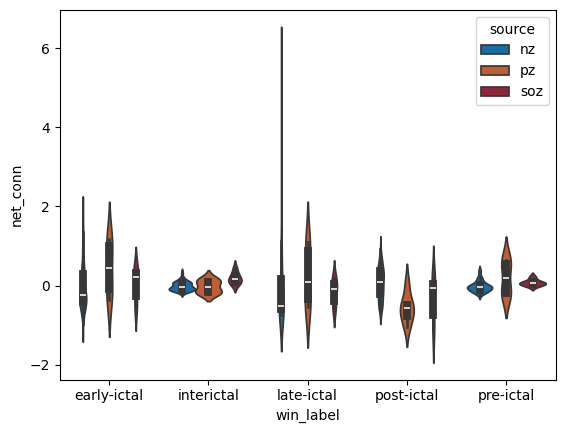

In [40]:
sns.violinplot(win_df[win_df.eventID == '7'], x='win_label', y='net_conn', hue='source', palette=COLOR_MAP)

In [69]:
data = []
labels = []
for event in win_df.eventID.unique():
    x_event = win_df[win_df.eventID == event].pivot(index='src_bip', columns='win_label', values='net_conn')
    data.append(x_event.values)
    bips = x_event.index.values
    y_event = [bip_labels[reg] for reg in bips]
    labels.append(y_event)
X = np.concatenate(data)
Y = np.concatenate(labels)

NameError: name 'win_df' is not defined

In [134]:
with open("../data/classify/Epat13_X.npy", 'wb') as f:
    np.save(f, X)
with open("../data/classify/Epat13_y.npy", "wb") as f:
    np.save(f,Y)

In [135]:
with open("../data/classify/Epat13_X.npy", 'rb') as f:
    X_tst = np.load(f)

In [138]:
(X_tst == X).all()

np.True_

In [77]:
Counter(Y)

Counter({np.str_('nz'): 729, np.str_('pz'): 153, np.str_('soz'): 18})

In [119]:
# building a per-eventSVM or logistic regression
random_state = np.random.RandomState(69420)
n_samples, n_features = X.shape
n_classes = len(np.unique(Y))
(
    X_train,
    X_test,
    y_train,
    y_test,
) = train_test_split(X,Y , test_size=0.5, stratify=Y, random_state=3)

In [120]:
classifier = LogisticRegression()
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

In [127]:
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)
label_binarizer.transform(['soz'])
class_of_interest = "soz"
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
class_id

np.int64(2)

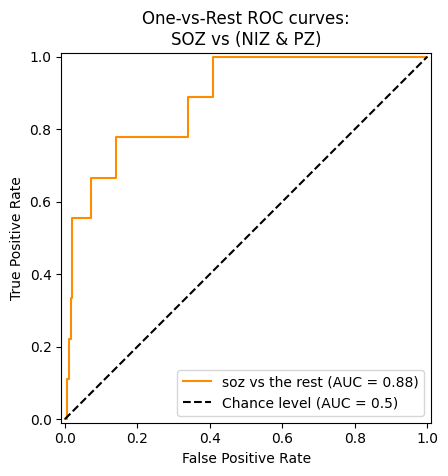

In [ ]:
import matplotlib.pyplot as plt

from sklearn.metrics import RocCurveDisplay

display = RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="One-vs-Rest ROC curves:\nSOZ vs (NIZ & PZ)",
)

### Confusion Matrices

In [15]:
import numpy as np 
import dill as pickle
with open('../data/conf_mat_BEST_858.pkl', 'rb') as f:
    confs = pickle.load(f)
agg_confs = np.zeros((3,3,len(confs)))
for i, (mat, labels) in enumerate(confs):
    if len(labels) ==3:
        inds = np.argsort(labels)
        ordered_mat = mat[inds,:]
        ordered_mat = ordered_mat[:,inds]
    
        agg_confs[:,:,i] =  ordered_mat
    else:
        assert 'soz' in labels and 'nz' in labels, f"Check labels: {labels}"
        soz_ind = np.where('soz' == labels)[0]
        niz_ind = np.where('nz' == labels)[0]

        agg_confs[0,0,i] = mat[niz_ind, niz_ind]
        agg_confs[0,2,i] = mat[niz_ind, soz_ind]
        agg_confs[2,2,i] = mat[soz_ind, soz_ind]
        agg_confs[2,0,i] = mat[soz_ind,niz_ind]

In [16]:
mean_conf = np.mean(agg_confs, axis=2)
mean_conf

array([[0.91811447, 0.03528392, 0.04660161],
       [0.20456936, 0.72768033, 0.06775031],
       [0.07990049, 0.06197108, 0.85812843]])

In [25]:
std_conf = np.std(agg_confs, axis=2)
std_conf

array([[0.00174533, 0.00132774, 0.00199724],
       [0.04085111, 0.06242701, 0.05864175],
       [0.04430864, 0.03665312, 0.07947079]])

In [ ]:

sns.heatmap(mean_conf)

NameError: name 'sns' is not defined

# Sankey and Network X Madness

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

:Sankey   [source,target]   (value)
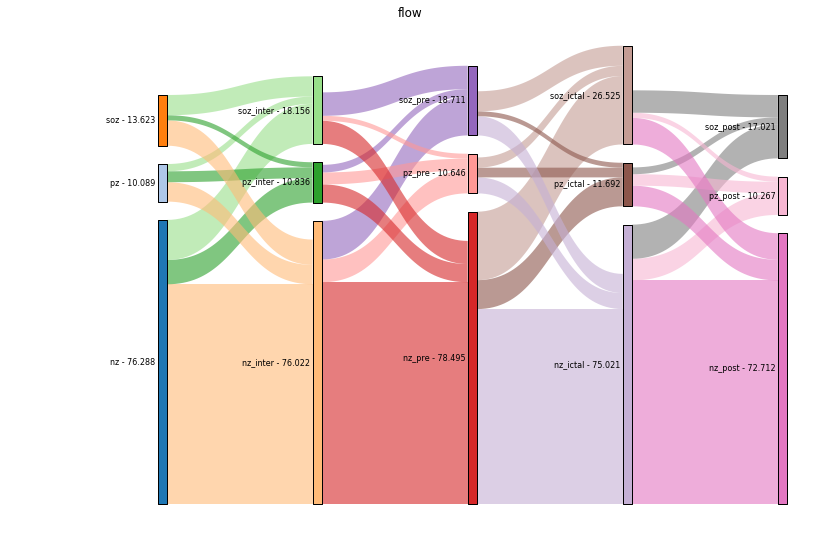

In [28]:
# hv.extension('matplolib')
# sankey = hv.Sankey(flow_stats_df, label="flow")
# sankey.opts(label_position='left', edge_color='target', node_color='index',cmap='tab20')
# # hv.save(sankey, "../viz/soz_flow.pdf", fmt='pdf')

## Plottin Directed Graphs

In [100]:
flow_stats_df['period'] = flow_stats_df.target.apply(lambda x: x.split("_")[1])
flow_df = flow_stats_df
flow_df.source = flow_df.source.apply(lambda x : x.split("_")[0])
flow_df.target = flow_df.target.apply(lambda x : x.split("_")[0])
flow_df

,source,target,value,period
0,nz,nz,58.993035,inter
1,nz,pz,6.527068,inter
2,nz,soz,10.767942,inter
3,pz,nz,5.208995,inter
4,pz,pz,2.932386,inter
5,pz,soz,1.947723,inter
6,soz,nz,6.805295,inter
7,soz,pz,1.376816,inter
8,soz,soz,5.440740,inter
0,nz,nz,59.543089,pre


,source,target,value
0,nz_inter,nz,59.543089
1,nz_inter,pz,6.110856
2,nz_inter,soz,10.368323
3,pz_inter,nz,4.886424
4,pz_inter,pz,3.206139
5,pz_inter,soz,2.042328
6,soz_inter,nz,6.213590
7,soz_inter,pz,1.328871
8,soz_inter,soz,6.300380


In [103]:
period_flow_df

,source,target,value,period
0,nz,nz,58.993035,inter
1,nz,pz,6.527068,inter
2,nz,soz,10.767942,inter
3,pz,nz,5.208995,inter
4,pz,pz,2.932386,inter
5,pz,soz,1.947723,inter
6,soz,nz,6.805295,inter
7,soz,pz,1.376816,inter
8,soz,soz,5.440740,inter


In [118]:
PERIOD

['inter', 'pre', 'ictal', 'post']

[19.664345069982012, 2.1756893398872483, 3.5893140476490895, 1.7363315182483843, 0.9774618563175216, 0.6492409369573793, 2.2684317851045455, 0.45893870483958543, 1.813580074347566]


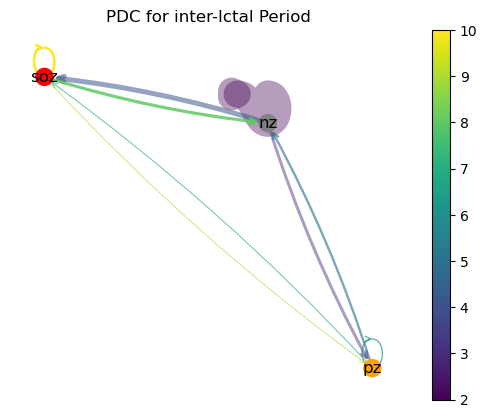

In [136]:
import networkx as nx

seed = 1640


for period in [PERIOD[0]]:
    period_flow_df =  flow_df[flow_df.period==period].drop('period',axis=1)
    edge_list = [(src, tgt, {'weight':val}) for src, tgt, val in period_flow_df.values]
    G, pos = setup_graph(edge_list, seed)
    out_f = f'PDC_{period}_flow.pdf'
    weights = []
    for e in G.edges:
        weights.append(G[e[0]][e[1]][0]['weight']/3)
    print(weights)
    plot_graph(G, pos, weights, out_f)
    plt.title(f'PDC for {period}-Ictal Period')
    break
    



In [111]:
out_f

'post_flow.pdf'

In [24]:
viz_df

,source,target,value
0,nz,nz,58.993035
1,nz,pz,6.527068
2,nz,soz,10.767942
3,pz,nz,5.208995
4,pz,pz,2.932386
5,pz,soz,1.947723
6,soz,nz,6.805295
7,soz,pz,1.376816
8,soz,soz,5.440740


In [81]:
node_labels = [ n for n in G.nodes]
node_labels

['nz', 'pz', 'soz']

In [120]:
#render color plots

# def get_flow_df(full_flow_df, period):
#     viz_df = full_flow_df[full_flow_df.target.isin([f'nz_{period}', f'pz_{period}',f'soz_{period}'])]
#     viz_df.target = viz_df.target.apply(lambda x: x.split("_")[0])
#     return viz_df

def setup_graph(edge_list, seed):

    G = nx.MultiDiGraph()
    G.add_edges_from(edge_list)
    pos = nx.spring_layout(G, seed=seed)
    return G, pos

def plot_graph(G, pos, weights, out_f, cmap = plt.cm.viridis, n_size=150):

    #setup
    node_sizes = [n_size  for i in range(len(G))]
    M = G.number_of_edges()
    edge_colors = range(2, M + 2)
    edge_alphas = [(5 + i) / (M + 4) for i in range(M)]


    nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=['gray','orange','red'])
    nx.draw_networkx_labels(G, pos)
    edges = nx.draw_networkx_edges(
        G,
        pos,
        arrows=True,
        node_size=node_sizes,
        arrowstyle="->",
        arrowsize=10,
        edge_color=edge_colors,
        edge_cmap=cmap,
        width=weights,
        connectionstyle='arc3, rad=0.05'
    )
    # set alpha value for each edge
    for i in range(M):
        edges[i].set_alpha(edge_alphas[i])
    pc = matplotlib.collections.PatchCollection(edges, cmap=cmap)
    pc.set_array(edge_colors)

    ax = plt.gca()
    ax.set_axis_off()
    plt.colorbar(pc, ax=ax)
    plt.savefig(f'../viz/{out_f}')



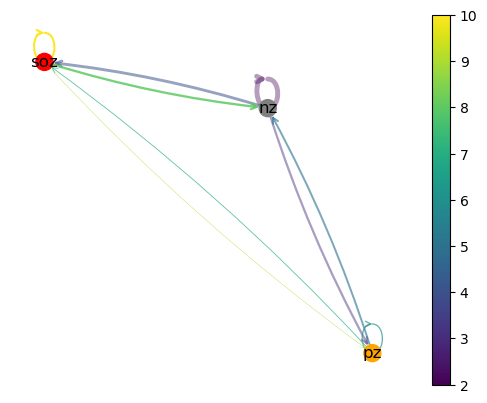

In [85]:
plot_graph(G, pos, node_sizes, 'inter_conn.pdf')